<a href="https://colab.research.google.com/github/jdasam/mas1004-2023/blob/main/live_coding/7_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST classification with CNN


In [1]:
!pip install tqdm

import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
# make plt grayscale as default
plt.rcParams['image.cmap'] = 'gray'

DEV = 'cuda' # Use GPU # library for NVIDIA GPU
assert torch.cuda.is_available(), "Make sure you run this Colab in GPU"

## 0. Download Dataset

In [2]:
train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 148706680.85it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 119228045.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29878907.29it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23317660.67it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# See how our data looks like
# you can get the i-th data from the dataset class using dataset[i]
train_data[0] # this will return (image tensor, label)

Label is 8


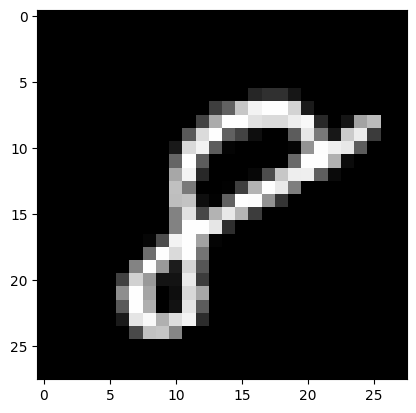

In [3]:
data_idx = 59999
# You can load the data sample from the dataset, using [idx]
img, label = train_data[data_idx] # get the data_idx-th sample from the train_data
img = img.squeeze()

plt.imshow(img), # plt.imshow visualize 2D image
print(f'Label is {label}') # f means formatted string

tensor([[ 1,  1,  1],
        [ 0,  0,  0],
        [-1, -1, -1]])


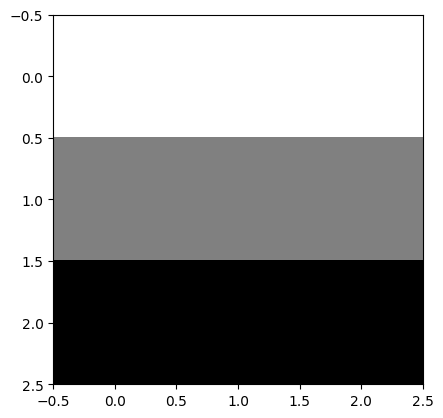

In [22]:
# make simple kernel and apply it to the image
# plt.imshow(img[10:13, 10:13])
sliced_input = img[10:13, 10:13]

custom_kernel = torch.tensor([[1, 1, 1], [0, 0, 0], [-1, -1, -1] ])
print(custom_kernel)
plt.imshow(custom_kernel)
# kernel_output = (sliced_input * custom_kernel).sum() # take the element-wise multiplication and take sum
# kernel_output

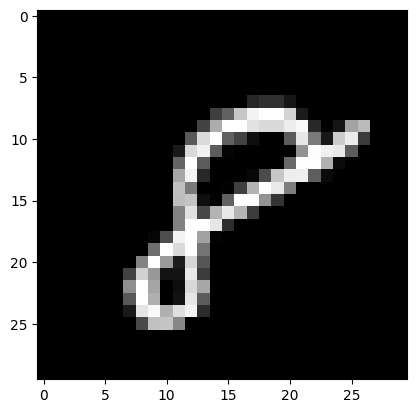

In [30]:
pad_size = 1
padded_img = torch.zeros(img.shape[0] + pad_size * 2, img.shape[1] + pad_size *2 )
padded_img.shape
padded_img[pad_size:-pad_size, pad_size:-pad_size] = img
plt.imshow(padded_img)

In [31]:
# We will move our kernel throughout the image and see the result
kernel_size = 3

total_outputs = []
img = padded_img
for h in range(img.shape[0] - (kernel_size -1) ):
  row_output = []
  for w in range(img.shape[1] - (kernel_size -1) ):
    sliced_img = img[h:h+3, w:w+3]
    convolution_output = (sliced_img * custom_kernel).sum().item()
    # print(convolution_output)
    row_output.append(convolution_output)
  # print(row_output)
  total_outputs.append(row_output)
total_outputs = torch.tensor(total_outputs)
total_outputs.shape

torch.Size([28, 28])

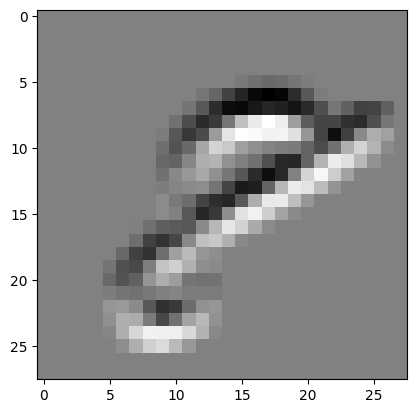

In [32]:
plt.imshow(total_outputs)

# 0.0 Using DataLoader

In [ ]:
train_data

In [ ]:
class Dataset:
  def __init__(self, data):
    self.data = data

  # To implement the dataset, you have to declare two methods
  # __getitem__ and __len__

  def __getitem__(self, idx):
    # this method is called when you do train_set[idx]
    # here, we want to return our idx-th datasample, in proper format
    img, label = self.data[idx]
    # return img, label
    return img.reshape(-1), label

  def __len__(self):
    # how many datasample we have in our dataset?
    # what is the maximum valid idx for __getitem__
    return len(self.data)

train_set = Dataset(train_data)
# train_set[15]
len(train_set)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)

for batch in train_loader:
  imgs, labels = batch
  break
imgs.shape


## 1. Make a Model

In [ ]:
class Classifier(nn.Module):
  def __init__(self, input_dim=784, num_class=10):
    super().__init__()
    # Let's make three layer models

    # What we know: input_dim = 784
    # number_of_categories = 10
    hidden_dim = 64
    hidden_dim2 = 32

    self.layer1 = nn.Linear(input_dim, hidden_dim)
    self.layer2 = nn.Linear(hidden_dim, hidden_dim2)
    self.layer3 = nn.Linear(hidden_dim2, num_class)
    # self.layer = nn.Linear(784, 123)

  def forward(self, x): # x is an input
    # x is a tensor with a shape of [Num samples, 784]

    # we want to predict the probability of each category label for a given input
    # we have 10 different categories in our dataset

    x = self.layer1(x)
    x = x.relu()
    x = self.layer2(x)
    x = x.relu()
    logit = self.layer3(x)
    prob = logit.softmax(dim=-1)
    return prob, logit


model = Classifier()

torch.set_printoptions(sci_mode=False)
pred, logit = model(imgs)
pred.shape, pred[:10]

## 2. Training

### 2.1 Make a Loss Function
- Define Negative Log Likelihood Loss
  - $L = -\sum_{i=1}^n\log(\hat{y}_{i}^{(c)})$
  - $y_{i}^{(c)} \in (0, 1)$: predicted probability for $i$-th sample to be class $c$, where $c$ is the ground truth label for $i$-th sample
- Define Cross Entropy Loss
  - $L = -\sum_{i=1}^ny_{i}\log(\hat{y}_{i})$
  - $ y_{i} \in (0,1)^C$: ground truth label for $i$-th sample to be class $c$. $C$ denotes the number of classes.
    - One-hot encoding: $y_{i} = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]$
  - $ \hat{y}_{i} \in (0, 1)^C$: predicted probability for $i$-th sample to be class $c$
    - e.g.: $\hat{y}_{i} = [0.1, 0.1, 0.5, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1]$

In [ ]:
def get_negative_log_likelihood(pred, target, eps=1e-8):
  predicted_probs = []
  # for i in range(len(pred)): #len(pred) means number of samples, or pred.shape[0]
  #   i_th_pred = pred[i]
  #   correct_label = target[i]
  #   predicted_prob_for_correct_class = i_th_pred[correct_label]
  #   # print(i_th_pred, correct_label, predicted_prob_for_correct_class)
  #   predicted_probs.append(predicted_prob_for_correct_class)

  # predicted_probs = torch.tensor(predicted_probs)
  predicted_probs = pred[torch.arange(len(target)), target]
  return -torch.log(predicted_probs + eps).mean()

def get_cross_entropy(pred, target, eps=1e-8):
  return

def make_one_hot_vector(target, num_class=10):
  return

# pred.shape, label_tensor.shape
# print(pred[:5])
# print(label_tensor[:5])

# predicted_probs = []
# for i in range(len(pred)): #len(pred) means number of samples, or pred.shape[0]
#   i_th_pred = pred[i]
#   correct_label = label_tensor[i]
#   predicted_prob_for_correct_class = i_th_pred[correct_label]
#   # print(i_th_pred, correct_label, predicted_prob_for_correct_class)
#   predicted_probs.append(predicted_prob_for_correct_class)

# predicted_probs = torch.tensor(predicted_probs)

loss = get_negative_log_likelihood(pred, label_tensor)
loss

In [ ]:
# you can index tensor by list of indices
# [(0, target[0]), (1, target[1]), (2, target[2])]
# for i, c in zip(torch.arange(len(label_tensor)), label_tensor):
#   print(i,c)

pred[torch.arange(len(label_tensor)), label_tensor]

In [ ]:
-torch.log(predicted_probs).mean()

### 2.2 Define Training Loop

In [ ]:
def train_one_step(model, optimizer, loss_function, input, target):
  pred, logit = model(input) # forward pass. compute the prediction
  loss = loss_function(pred, target) # compute the loss
  loss.backward() # backpropagate theloss. compute the gradient
  optimizer.step() # update the parameters based on each gradient
  optimizer.zero_grad() # clear the gradient for every parameters
  return loss.item() # return the loss value


### 2.3 Make Batch

In [ ]:
def get_batch(input_tensor, label_tensor, batch_size, start_idx):
  # slice input tensor from start_idx:start_idx + batch_size

  return input_tensor[start_idx:start_idx+batch_size], label_tensor[start_idx:start_idx+batch_size]

batch_size = 64
start_idx = 10
batch_input, batch_label = get_batch(data_tensor, label_tensor, batch_size, start_idx)
(batch_input[0] == data_tensor[10]).all()

### 2.4 Train

In [ ]:
DEV

In [ ]:


model = Classifier()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1000, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = get_negative_log_likelihood

losses = []
num_epochs = 5

model.to(DEV) # move model to cuda. Move model's parameter on GPU's VRAM

for epoch in tqdm(range(num_epochs)):
  for batch in tqdm(train_loader, leave=False):
    input_batch, target_batch = batch
    input_batch = input_batch.to(DEV)  # Movetensor to GPU's VRAM
    target_batch = target_batch.to(DEV)
    loss = train_one_step(model, optimizer, loss_function, input_batch, target_batch)
    losses.append(loss)




In [ ]:
plt.plot(losses)

In [ ]:
test_loader = torch.utils.data.DataLoader(Dataset(test_data), batch_size=1000, shuffle=False)

test_batch = next(iter(test_loader))
# this will make something like "batch in test_loader" (iterator)
# and only gets the first one
imgs, labels = test_batch
# imgs.shape

pred, logit = model(imgs.to(DEV))
pred.shape

In [ ]:
pred[0:3]

In [ ]:
# torch.argmax
# return the indices that has maximum value
predicted_labels = torch.argmax(pred, dim=1).cpu()
predicted_labels[:10]

In [ ]:
(predicted_labels == labels).sum().item() / len(labels)

In [ ]:
torch.where(predicted_labels != labels)
# it gives in which indices our model made wrong predictions

In [ ]:
idx = 241
img, label = test_data[idx]
predicted_lb = predicted_labels[idx].item()

print(f"GT Label: {label}, Predicted: {predicted_lb}")
plt.imshow(img.squeeze())